In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.2'
# spark_version = 'spark-3.5.2'
# os.environ['SPARK_VERSION']=spark_version

# # Install Spark and Java
# !apt-get update
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
# !tar xf $SPARK_VERSION-bin-hadoop3.tgz
# !pip install -q findspark

# # Set Environment Variables
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# # Start a SparkSession
# import findspark
# findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.8 kB]
Get:14 http://archive.ubuntu.com/

In [11]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark: SparkSession = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [ ]:
# 1. Read in the csv into a DataFrame.
from pyspark import SparkFiles
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
spark.sparkContext.addFile(url)
energydata_df = spark.read.csv(SparkFiles.get("energydata_complete.csv"), sep=",", header=True)
energydata_df.show()



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
data = pd.read_csv(url)

# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Feature engineering: Extract hour, day, month, and week from 'date'
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week

# Drop 'date' as it's now redundant
data = data.drop(columns=['date'])

# Display the first few rows
print(data.head())


   Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   
3          50      40  19.89  46.066667  19.2  44.590000  19.79  45.000000   
4          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000   

          T4       RH_4  ...  RH_out  Windspeed  Visibility  Tdewpoint  \
0  19.000000  45.566667  ...    92.0   7.000000   63.000000        5.3   
1  19.000000  45.992500  ...    92.0   6.666667   59.166667        5.2   
2  18.926667  45.890000  ...    92.0   6.333333   55.333333        5.1   
3  18.890000  45.723333  ...    92.0   6.000000   51.500000        5.0   
4  18.890000  45.530000  ...    92.0   5.666667   47.666667        4.9   

         rv1        rv2  hour  day  month  week  
0  13.275433  13.275433    17   11  

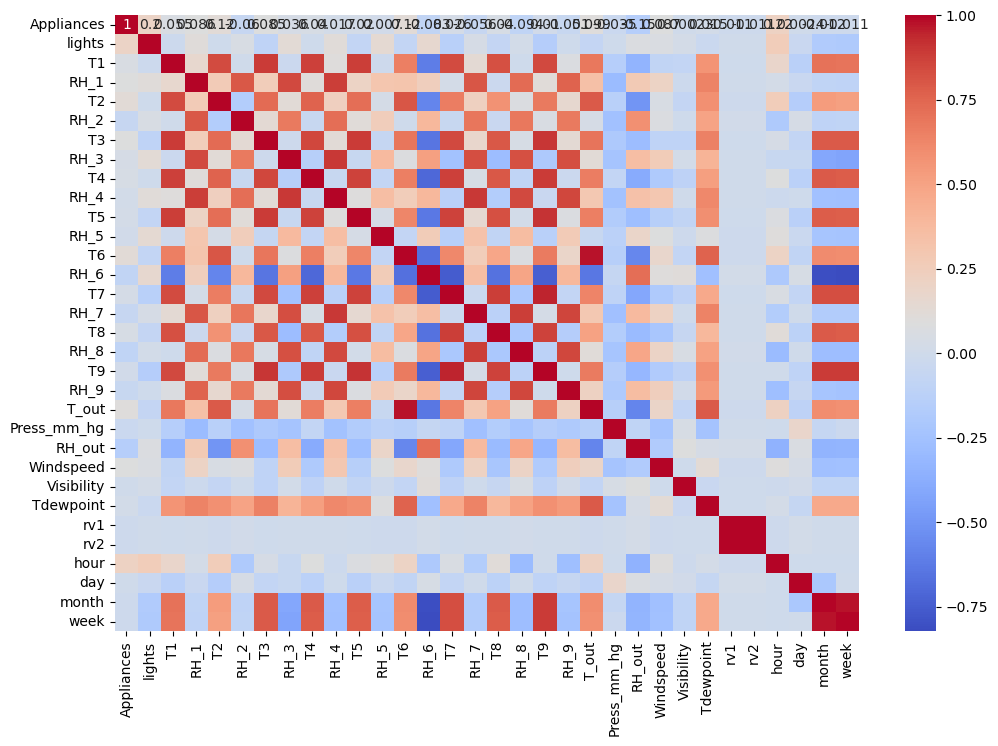

c:\Users\mrindfleisch\AppData\Local\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


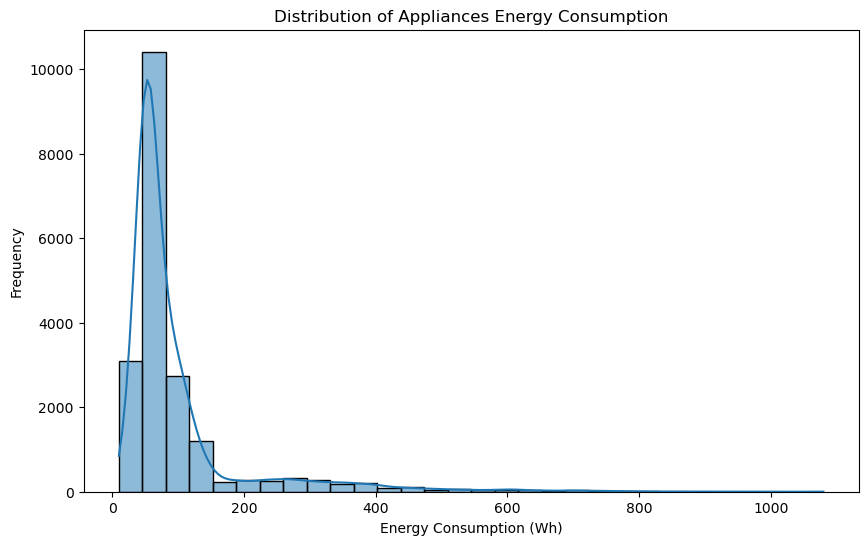

In [3]:
# Correlation matrix to see how features relate to the target variable 'Appliances'
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Distribution of the target variable 'Appliances'
plt.figure(figsize=(10, 6))
sns.histplot(data['Appliances'], kde=True, bins=30)
plt.title('Distribution of Appliances Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()


In [4]:
# Selecting features and target variable
X = data.drop(columns=['Appliances', 'lights'])  # Dropping 'lights' as it may not be necessary
y = data['Appliances']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, R^2: {r2_lr}")


Linear Regression - MAE: 53.40029640136626, RMSE: 92.37550911628023, R^2: 0.14728120247101295


In [6]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}, R^2: {r2_rf}")


Random Forest - MAE: 29.994552824930327, RMSE: 63.77672350559963, R^2: 0.5935411776632


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [16]:
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X_train_scaled, y_train.ravel())

RandomForestRegressor(random_state=42)

In [18]:
accuracy_score(y_test, rf_model2.predict(X_test_scaled))
accuracy_score(y_train, rf_model2.predict(X_train_scaled))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [15]:
# y_test.shape
accuracy_score(y_test.ravel(), rf_model.predict(X_test_scaled))
# accuracy_score(y_train, rf_model.predict(X_train_scaled))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [19]:
predictions = rf_model.predict(X_test_scaled)
print(classification_report(y_test, predictions))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [20]:
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.15717647660345235, 'hour'),
 (0.048803945848842005, 'T3'),
 (0.04652337999106255, 'RH_3'),
 (0.04589963644353567, 'Press_mm_hg'),
 (0.037951551458033125, 'RH_2'),
 (0.03750561801965466, 'T_out'),
 (0.034408828848053595, 'RH_5'),
 (0.033892111858908766, 'RH_1'),
 (0.03372502950526663, 'T8'),
 (0.033290320725045, 'RH_8'),
 (0.032749851247843784, 'RH_9'),
 (0.03191392686699845, 'T6'),
 (0.03175164945140038, 'Tdewpoint'),
 (0.03168941265435902, 'RH_4'),
 (0.02967418280303841, 'RH_out'),
 (0.02947691366143611, 'RH_6'),
 (0.0293902564975585, 'RH_7'),
 (0.02924107773337817, 'T4'),
 (0.0281816583699931, 'T2'),
 (0.02698565985939886, 'T7'),
 (0.026097350768684496, 'T5'),
 (0.024586635568760822, 'T1'),
 (0.023165332065980277, 'Windspeed'),
 (0.02199103896722351, 'Visibility'),
 (0.019879307295947134, 'rv2'),
 (0.01909731913009691, 'week'),
 (0.018195319694840083, 'rv1'),
 (0.01734396802860917, 'T9'),
 (0.01636544624079584, 'day'),
 (0.003046793791802671, 'month')]

C:\Users\mrindfleisch\AppData\Local\Temp\ipykernel_27612\839578106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_importances.drop(columns=1, inplace=True)
C:\Users\mrindfleisch\AppData\Local\Temp\ipykernel_27612\839578106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_importances.rename(columns={0: 'Feature Importances'}, inplace=True)


<Axes: title={'center': 'Features Importances'}, ylabel='1'>

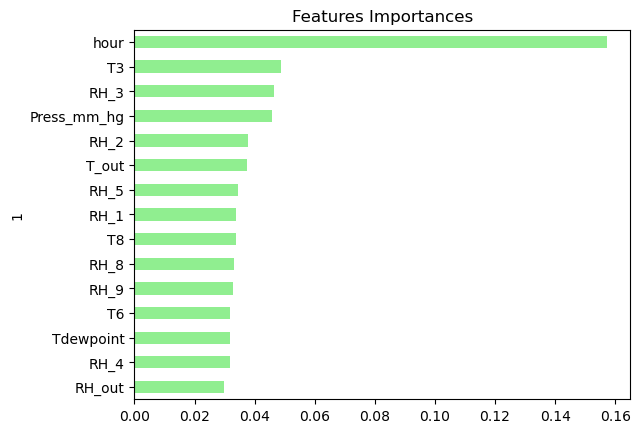

In [21]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
top_importances = importances_df[:15]
top_importances.set_index(top_importances[1], inplace=True)
top_importances.drop(columns=1, inplace=True)
top_importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = top_importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [22]:
# Comparing Linear Regression and Random Forest

models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'R^2': [r2_lr, r2_rf]
})

print(models)




               Model        MAE       RMSE       R^2
0  Linear Regression  53.400296  92.375509  0.147281
1      Random Forest  29.994553  63.776724  0.593541


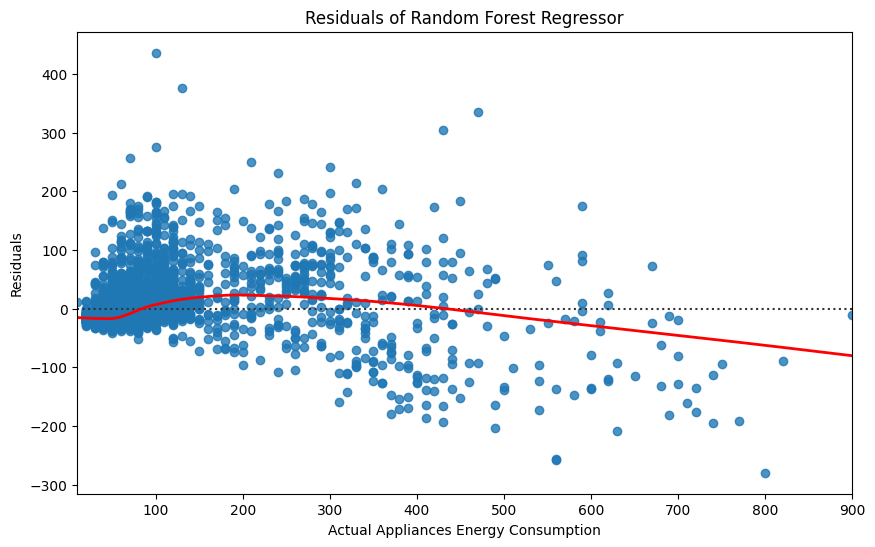

In [23]:
# Residual Plot for Random Forest
plt.figure(figsize=(10, 6))
# Use 'x' and 'y' as named arguments for clarity and compatibility
sns.residplot(x=y_test, y=y_pred_rf, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals of Random Forest Regressor')
plt.xlabel('Actual Appliances Energy Consumption')
plt.ylabel('Residuals')
plt.show()

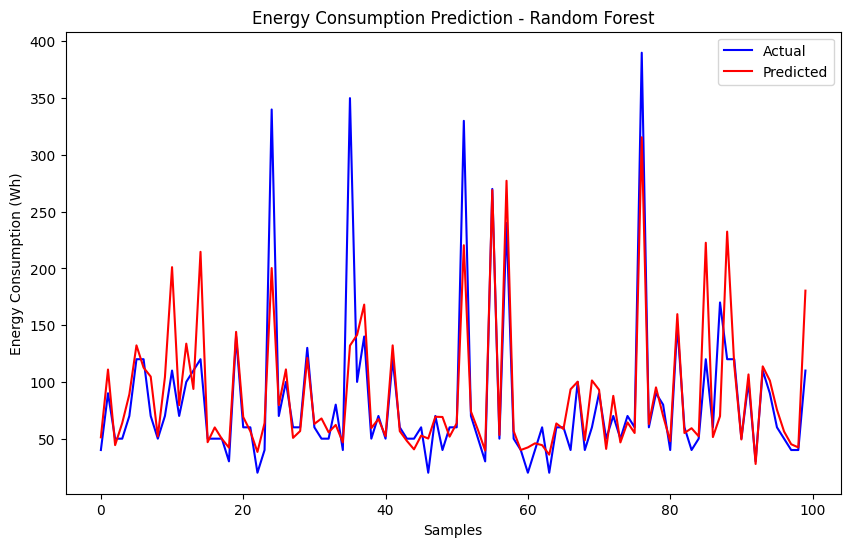

In [17]:
# Visualizing the prediction vs actual for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred_rf[:100], label='Predicted', color='red')
plt.title('Energy Consumption Prediction - Random Forest')
plt.xlabel('Samples')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.show()


- Model lights as the target instead of appliances

In [22]:
# Selecting features and target variable
X = data.drop(columns=['Appliances', 'lights'])  # Dropping 'lights' as it may not be necessary
y = data['lights']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Linear Regression
lr_model2 = LinearRegression()
lr_model2.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_lr = lr_model2.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, R^2: {r2_lr}")


Linear Regression - MAE: 4.87046459767955, RMSE: 6.893687202281166, R^2: 0.2241106184445084


In [24]:
# Random Forest Regressor
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model2.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}, R^2: {r2_rf}")


Random Forest - MAE: 2.3641246516341528, RMSE: 4.279512058734774, R^2: 0.7009903738016089


In [25]:
# Comparing Linear Regression and Random Forest

models2 = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'R^2': [r2_lr, r2_rf]
})

print(models2)


               Model       MAE      RMSE       R^2
0  Linear Regression  4.870465  6.893687  0.224111
1      Random Forest  2.364125  4.279512  0.700990


c:\Users\mrindfleisch\AppData\Local\anaconda3\envs\dev\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


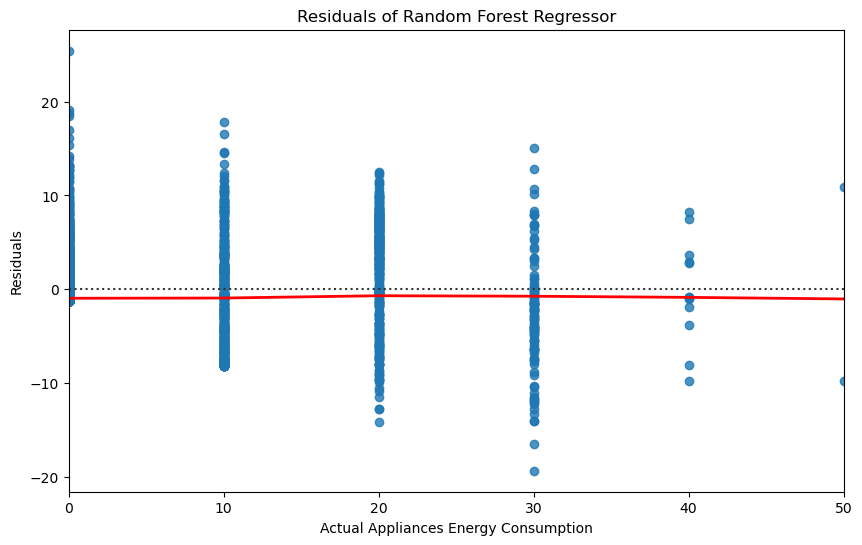

In [26]:
# Residual Plot for Random Forest
plt.figure(figsize=(10, 6))
# Use 'x' and 'y' as named arguments for clarity and compatibility
sns.residplot(x=y_test, y=y_pred_rf, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals of Random Forest Regressor')
plt.xlabel('Actual Appliances Energy Consumption')
plt.ylabel('Residuals')
plt.show()

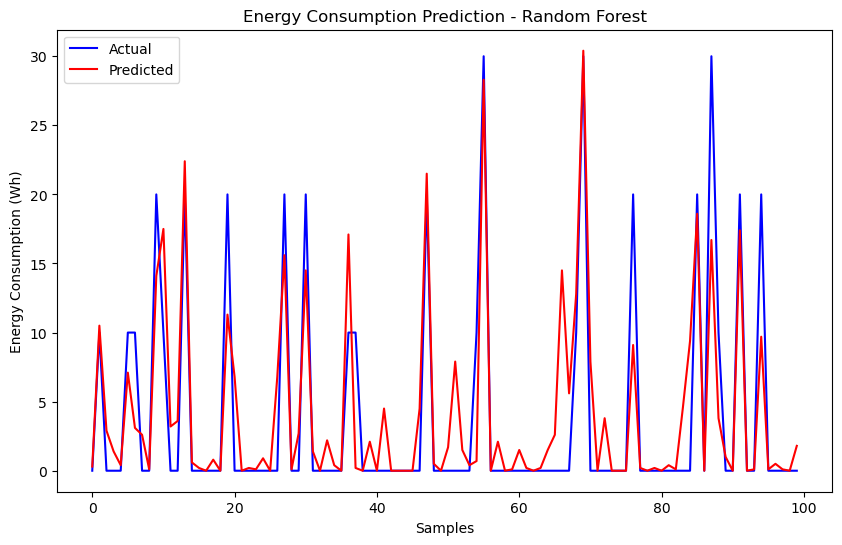

In [27]:
# Visualizing the prediction vs actual for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred_rf[:100], label='Predicted', color='red')
plt.title('Energy Consumption Prediction - Random Forest')
plt.xlabel('Samples')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.show()


In [28]:
importances = rf_model2.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model2.feature_importances_, X.columns), reverse=True)

[(0.11244899933148186, 'hour'),
 (0.09209034897786304, 'T4'),
 (0.05671048169437627, 'week'),
 (0.05176929601668378, 'RH_6'),
 (0.04116052670745466, 'Press_mm_hg'),
 (0.040054566029663966, 'RH_3'),
 (0.034560170819922326, 'RH_7'),
 (0.03404754089500116, 'RH_4'),
 (0.03334864166687196, 'RH_2'),
 (0.03323670287907642, 'T8'),
 (0.033223895846461717, 'RH_5'),
 (0.03321437242533434, 'Tdewpoint'),
 (0.0329918824800014, 'RH_9'),
 (0.030617034347659722, 'Windspeed'),
 (0.02796940706185426, 'RH_8'),
 (0.027455624064676463, 'T7'),
 (0.026432638845206736, 'RH_1'),
 (0.026105275420876328, 'T2'),
 (0.025216675053433973, 'T1'),
 (0.024843097742404043, 'T3'),
 (0.023606490391395295, 'T6'),
 (0.02240570970559823, 'T_out'),
 (0.022272147391958156, 'Visibility'),
 (0.022040708919163033, 'day'),
 (0.021549198492117956, 'T5'),
 (0.021097133865177167, 'RH_out'),
 (0.02049571272837134, 'T9'),
 (0.013599592350882688, 'rv2'),
 (0.013426411998053096, 'rv1'),
 (0.0020097158509786704, 'month')]

C:\Users\mrindfleisch\AppData\Local\Temp\ipykernel_27612\3291958812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_importances.drop(columns=1, inplace=True)
C:\Users\mrindfleisch\AppData\Local\Temp\ipykernel_27612\3291958812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_importances.rename(columns={0: 'Feature Importances'}, inplace=True)


<Axes: title={'center': 'Features Importances'}, ylabel='1'>

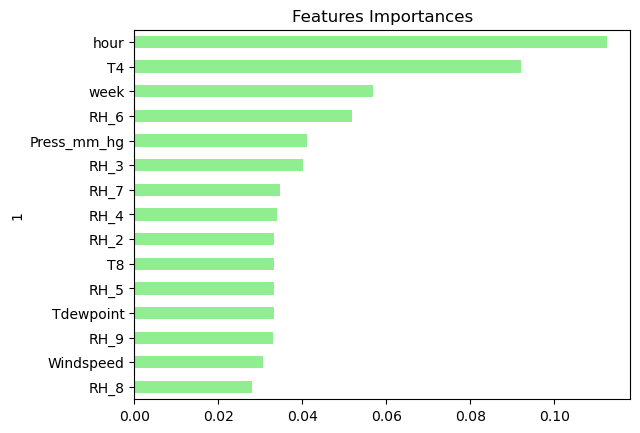

In [29]:
importances_df = pd.DataFrame(sorted(zip(rf_model2.feature_importances_, X.columns), reverse=True))
top_importances = importances_df[:15]
top_importances.set_index(top_importances[1], inplace=True)
top_importances.drop(columns=1, inplace=True)
top_importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = top_importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)